In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fowlkes_mallows_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

# Лабораторная работа 4. Кластеризация

## Цель работы

Изучение алгоритмов и методов кластеризации на практике.


## 1. Кластеризация синтетических данных

### Генерация данных

Функция для создания набора данных

In [2]:
def gen_data(n: int, seed: int) -> pd.DataFrame:
    '''
    Генерация набора случайных данных
    '''
    np.random.seed(seed)
    shift_matrix = np.array([
        [3, 3],
        [6, 9],
        [9, 3]
    ])

    data = np.random.randn(3, 2, n) + shift_matrix.reshape((3, 2, 1))
    data = np.swapaxes(data, 1, 2)
    data = data.reshape((-1, 2))
    data *= np.array([[20, 0.5]])

    df = pd.DataFrame({
        'x': data[:, 0],
        'y': data[:, 1]},
        columns=['x', 'y']
    )

    df = df.sample(frac=1.0)
    df = df.reset_index(drop=True)

    return df

Применяя функцию `gen_data`, необходимо создать два набора данных - train и test.

Параметры для генерации:

| выборка | n (число объектов в группе) | seed (зерно для случайной генерации) |
|---------|-----------------------------|--------------------------------------|
| `train` | 100                         | 42                                   |
| `test`  | 30                          | 43                                   |

In [3]:
seed_train  = 42
seed_test   = 43

train = gen_data(100,  seed_train)
test  = gen_data(30,   seed_test)

Вывод полученных данных на экран

In [4]:
train

,x,y
0,20.248622,2.860085
1,64.839245,1.530115
2,170.998691,1.174679
3,123.729086,4.339307
4,55.308257,0.928515
...,...,...
295,113.694615,5.152739
296,52.157837,1.586590
297,133.591955,4.814173
298,143.263275,5.225572


In [5]:
test

,x,y
0,60.280811,1.355780
1,115.525358,3.877187
2,106.104547,4.405808
3,186.679302,1.521523
4,180.597926,1.790670
...,...,...
85,51.215703,2.264493
86,190.701987,2.254384
87,119.520519,4.155014
88,76.744100,1.653966


В результате применения функции gen_data были получены 2 датафрейма, каждый из которых имеет фиксированное число объектов в каждой из трех групп.

### Стандартизация

Выполнение стандартизации наборов данных

In [6]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

### KMeans (n_clusters = 3)

Применение модели KMeans с тремя кластерами

In [7]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
train_labels = kmeans.fit_predict(train_scaled)

График кластеризации

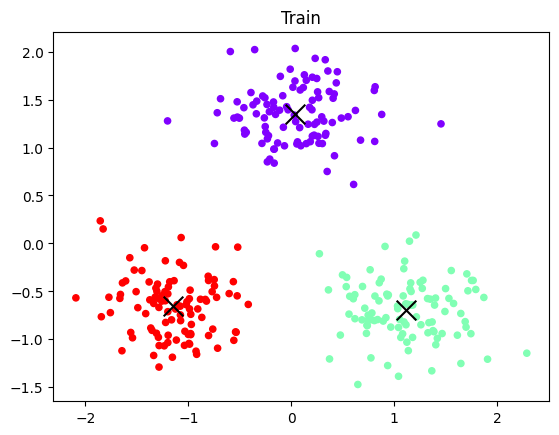

In [8]:
plt.scatter(train_scaled[:, 0], train_scaled[:, 1], c=train_labels, cmap='rainbow', s=20)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='x')
plt.title('Train')
plt.show()

Видно, что объекты хорошо разбились на кластеры

Получение предсказаний для тестовых данных

In [9]:
test_labels = kmeans.predict(test_scaled)

График кластеризации тестовых данных

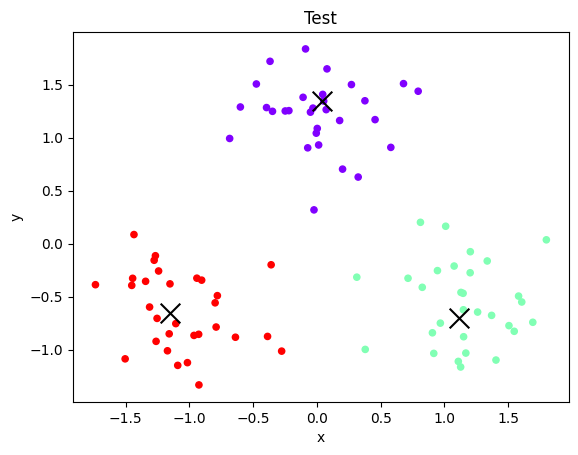

In [10]:
plt.scatter(test_scaled[:, 0], test_scaled[:, 1], c=test_labels, cmap='rainbow', s=20)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='x')
plt.title('Test')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Как и на тренировочной выборке, кластеризация отработала отлично

Расчет коэффициента силуэта для тестового и тренировочного набора данных

In [11]:
print(f'Silhouette Train: {silhouette_score(train_scaled, train_labels)}')
print(f'Silhouette Test: {silhouette_score(test_scaled, test_labels)}')

Silhouette Train: 0.7186325222753073
Silhouette Test: 0.6812610357158448


Полученные значения силуэта показывают, что кластеры хорошо отделены друг от друга.

Имеется деградация на тестовых данных, но так как она небольшая, нельзя говорить о переобучении.

Для того чтобы было удобнее сравнивать модели, можно создать отдельный датафрейм для хранения коэффициентов силуэта

In [12]:
silhouettes = pd.DataFrame(columns=['n_clusters', 'train_score', 'test_score'])

silhouettes.loc[len(silhouettes)] = {
    'n_clusters': 3,
    'train_score': silhouette_score(train_scaled, train_labels),
    'test_score': silhouette_score(test_scaled, test_labels)
}

silhouettes

,n_clusters,train_score,test_score
0,3,0.718633,0.681261


### KMeans (n_clusters = 2)

Применение модели KMeans с двумя кластерами

In [13]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
train_labels = kmeans.fit_predict(train_scaled)

График кластеризации

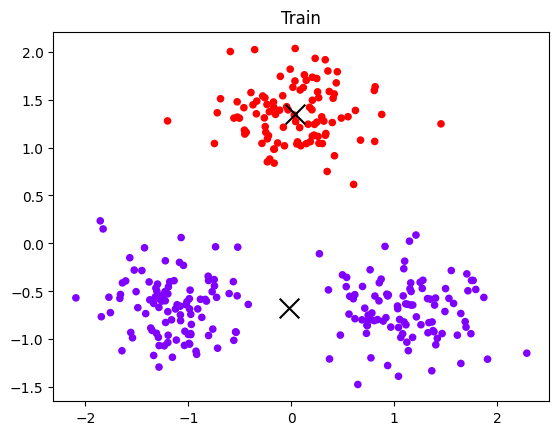

In [14]:
plt.scatter(train_scaled[:, 0], train_scaled[:, 1], c=train_labels, cmap='rainbow', s=20)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='x')
plt.title('Train')
plt.show()

Видно, что два кластера были объединены в один. При этом один кластер остался выделен очень четко.

Получение предсказаний для тестовых данных

In [15]:
test_labels = kmeans.predict(test_scaled)

График кластеризации тестовых данных

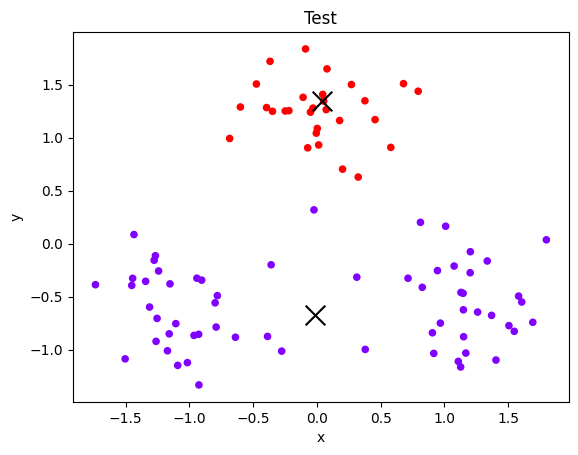

In [16]:
plt.scatter(test_scaled[:, 0], test_scaled[:, 1], c=test_labels, cmap='rainbow', s=20)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='x')
plt.title('Test')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Кластеризация отработала так же, как и на тренировочной выборке. Два кластера были объединены в один

Расчет коэффициента силуэта для тестового и тренировочного набора данных

In [17]:
print(f'Silhouette Train: {silhouette_score(train_scaled, train_labels)}')
print(f'Silhouette Test: {silhouette_score(test_scaled, test_labels)}')

Silhouette Train: 0.49969436457519656
Silhouette Test: 0.4464639857236824


Полученные значения силуэта показывают, что кластеризация отработала средне, даже плохо.

Имеется деградация на тестовых данных, но так как она небольшая, нельзя говорить о переобучении.

Запись полученных значений в датафрейм

In [18]:
silhouettes.loc[len(silhouettes)] = {
    'n_clusters': 2,
    'train_score': silhouette_score(train_scaled, train_labels),
    'test_score': silhouette_score(test_scaled, test_labels)
}

silhouettes

,n_clusters,train_score,test_score
0,3,0.718633,0.681261
1,2,0.499694,0.446464


### KMeans (n_clusters = 4)

Применение модели KMeans с 4-мя кластерами

In [19]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
train_labels = kmeans.fit_predict(train_scaled)

График кластеризации

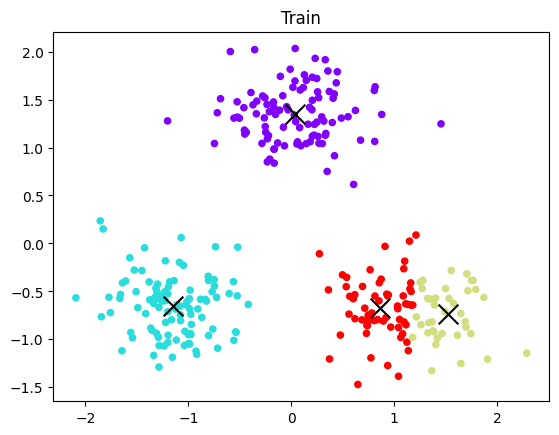

In [20]:
plt.scatter(train_scaled[:, 0], train_scaled[:, 1], c=train_labels, cmap='rainbow', s=20)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='x')
plt.title('Train')
plt.show()

Видно, что два кластера были выделены очень четко. При этом третий кластер модель попыталсь разбить на два.

Получение предсказаний для тестовых данных

In [21]:
test_labels = kmeans.predict(test_scaled)

График кластеризации тестовых данных

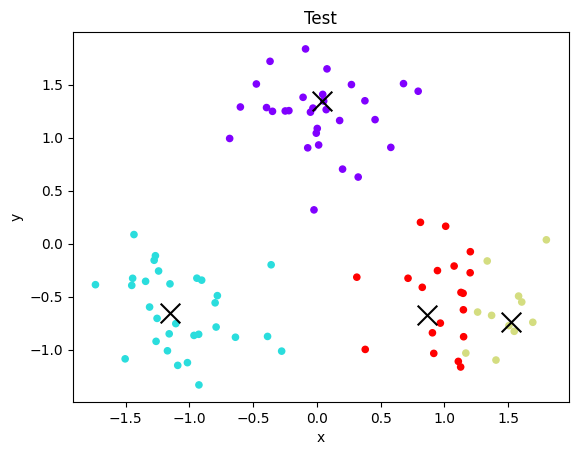

In [22]:
plt.scatter(test_scaled[:, 0], test_scaled[:, 1], c=test_labels, cmap='rainbow', s=20)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='x')
plt.title('Test')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Кластеризация отработала так же, как и на тренировочной выборке. Один кластер был разделен на два

Расчет коэффициента силуэта для тестового и тренировочного набора данных

In [23]:
print(f'Silhouette Train: {silhouette_score(train_scaled, train_labels)}')
print(f'Silhouette Test: {silhouette_score(test_scaled, test_labels)}')

Silhouette Train: 0.5937568788122392
Silhouette Test: 0.5208510110531454


Полученные значения силуэта показывают, что кластеризация отработала средне.

Имеется деградация на тестовых данных, но так как она небольшая, нельзя говорить о переобучении.

Запись полученных значений в датафрейм

In [24]:
silhouettes.loc[len(silhouettes)] = {
    'n_clusters': 4,
    'train_score': silhouette_score(train_scaled, train_labels),
    'test_score': silhouette_score(test_scaled, test_labels)
}

silhouettes

,n_clusters,train_score,test_score
0,3,0.718633,0.681261
1,2,0.499694,0.446464
2,4,0.593757,0.520851


### Сравнение моделей

Наибольшее значение силуэта у модели с n_clusters=3. Это неудивительно, так как данные были сгенерированы с тремя кластерами.

Остальные модели показали себя хуже.

Модель на 2 кластера показала себя хуже, чем модель на 4 кластера. Это связано с тем, что модель с n_clusters=2 смогла верно найти только один кластер, а второй кластер собрала из двух оставшихся.
Модель на 4 кластера смогла верно определить два кластера, а третий она разделила на два.


### Метод локтя

Расчет инерции для значений $k = [1, 10]$

In [25]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(train_scaled)
    inertia.append(kmeans.inertia_)

График метода локтя

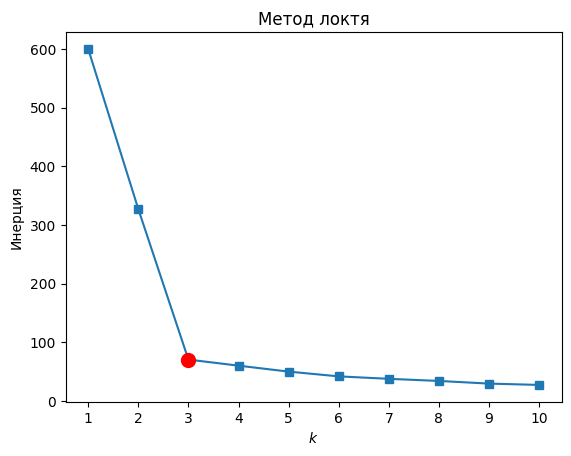

In [26]:
plt.plot(range(1, 11), inertia, marker='s')
plt.plot(3, inertia[2], marker='o', markersize=10, label='k=3', c='red')
plt.title('Метод локтя')

plt.xlabel('$k$')
plt.xticks(range(1, 11))
plt.ylabel('Инерция')

plt.show()

Оптимальное число кластеров для KMeans - точка перегиба. В данном случае, это $k=3$. Это подтверждает утверждение выше.

### Вывод по первой части работы

В первой части работы были сгенерированы тестовые и тренировочные наборы данных с тремя кластерами.

Были построены три модели KMeans с $k = 3$, $k = 2$ и $k = 4$. Рассчитанные значения коэффициента силуэта показали, что лучшая кластеризация достигается при $k = 3$.

Затем были вычислены значения инерции для десяти различных значений $k$.

Метод локтя, применённый к этим значениям инерции, подтвердил, что оптимальное число кластеров - это $k = 3$.

## 2. Кластеризация датасета

### Описание предметной области

Лабораторная работа выполняется по индивидуальному варианту №3

Данный датасет содержит информацию о заболеваемости раком, включая различные характеристики клеток. В таблице представлены следующие признаки:

| Признак                              | Диапазон значений |
|--------------------------------------|---------------------|
| **id**                               | -                   |
| **Толщина скопления**                | 1-10                 |
| **Однородность размера клеток**      | 1-10                 |
| **Однородность формы клеток**        | 1-10                 |
| **Краевая адгезия**                  | 1-10                 |
| **Размер отдельных эпителиальных клеток** | 1-10             |
| **Голые ядра**                       | 1-10                 |
| **Бледный хроматин**                 | 1-10                 |
| **Нормальные ядрышки**               | 1-10                 |
| **Митозы**                           | 1-10                 |
| **Класс**                            | 2 (доброкачественные), 4 (злокачественные) |

### Загрузка данных

Чтение датасета

In [27]:
df = pd.read_csv('https://raw.githubusercontent.com/m0rphed/suai-data-analysis-intro/refs/heads/lab04/data/datasets_04/3cancer.csv')
df

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


### Предварительная обработка данных

Колонку `id` можно отбросить из-за ненадобности

In [28]:
df = df.drop('id', axis=1)

Поиск пропущенных значений

In [29]:
df.isnull().sum()

clump_thickness      0
size_uniformity      0
shape_uniformity     0
marginal_adhesion    0
epithelial_size      0
bare_nucleoli        0
bland_chromatin      0
normal_nucleoli      0
mitoses              0
class                0
dtype: int64

В данных нет пропусков

In [30]:
df.duplicated().sum()

np.int64(236)

В данных 236 строк-дубликатов. Их необходимо удалить

In [31]:
print(f'Размер до удаления дубликатов: {df.shape}')
df = df.drop_duplicates()
print(f'Размер после удаления дубликатов: {df.shape}')

Размер до удаления дубликатов: (699, 10)
Размер после удаления дубликатов: (463, 10)


Размер датасета значительно уменьшился

Вывод уникальных значений каждого столбца для поиска ошибочных записей

In [32]:
for col in df.columns:
    print(f'{col}: {sorted(df[col].unique())}')

clump_thickness: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]
size_uniformity: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]
shape_uniformity: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]
marginal_adhesion: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]
epithelial_size: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]
bare_nucleoli: ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', '?']
bland_chromatin: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]
normal_nucleoli: [np.int64(1), 

Видно, что значения столбца `bare_nucleoli` не соответствуют своему типу, и имеют значения '?'. От них нужно избавиться

In [33]:
len(df[df['bare_nucleoli'] == '?'])

14

Таких значений 14

Удаление этих значений и изменение типа на целочисленный

In [34]:
df = df[df['bare_nucleoli'] != '?']
df['bare_nucleoli'] = df['bare_nucleoli'].astype(int)
df = df.reset_index(drop=True)

df

,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...
444,3,1,1,1,2,1,2,1,2,2
445,3,1,1,1,3,2,1,1,1,2
446,5,10,10,3,7,3,8,10,2,4
447,4,8,6,4,3,4,10,6,1,4


Гистограммы всех колонок датасета

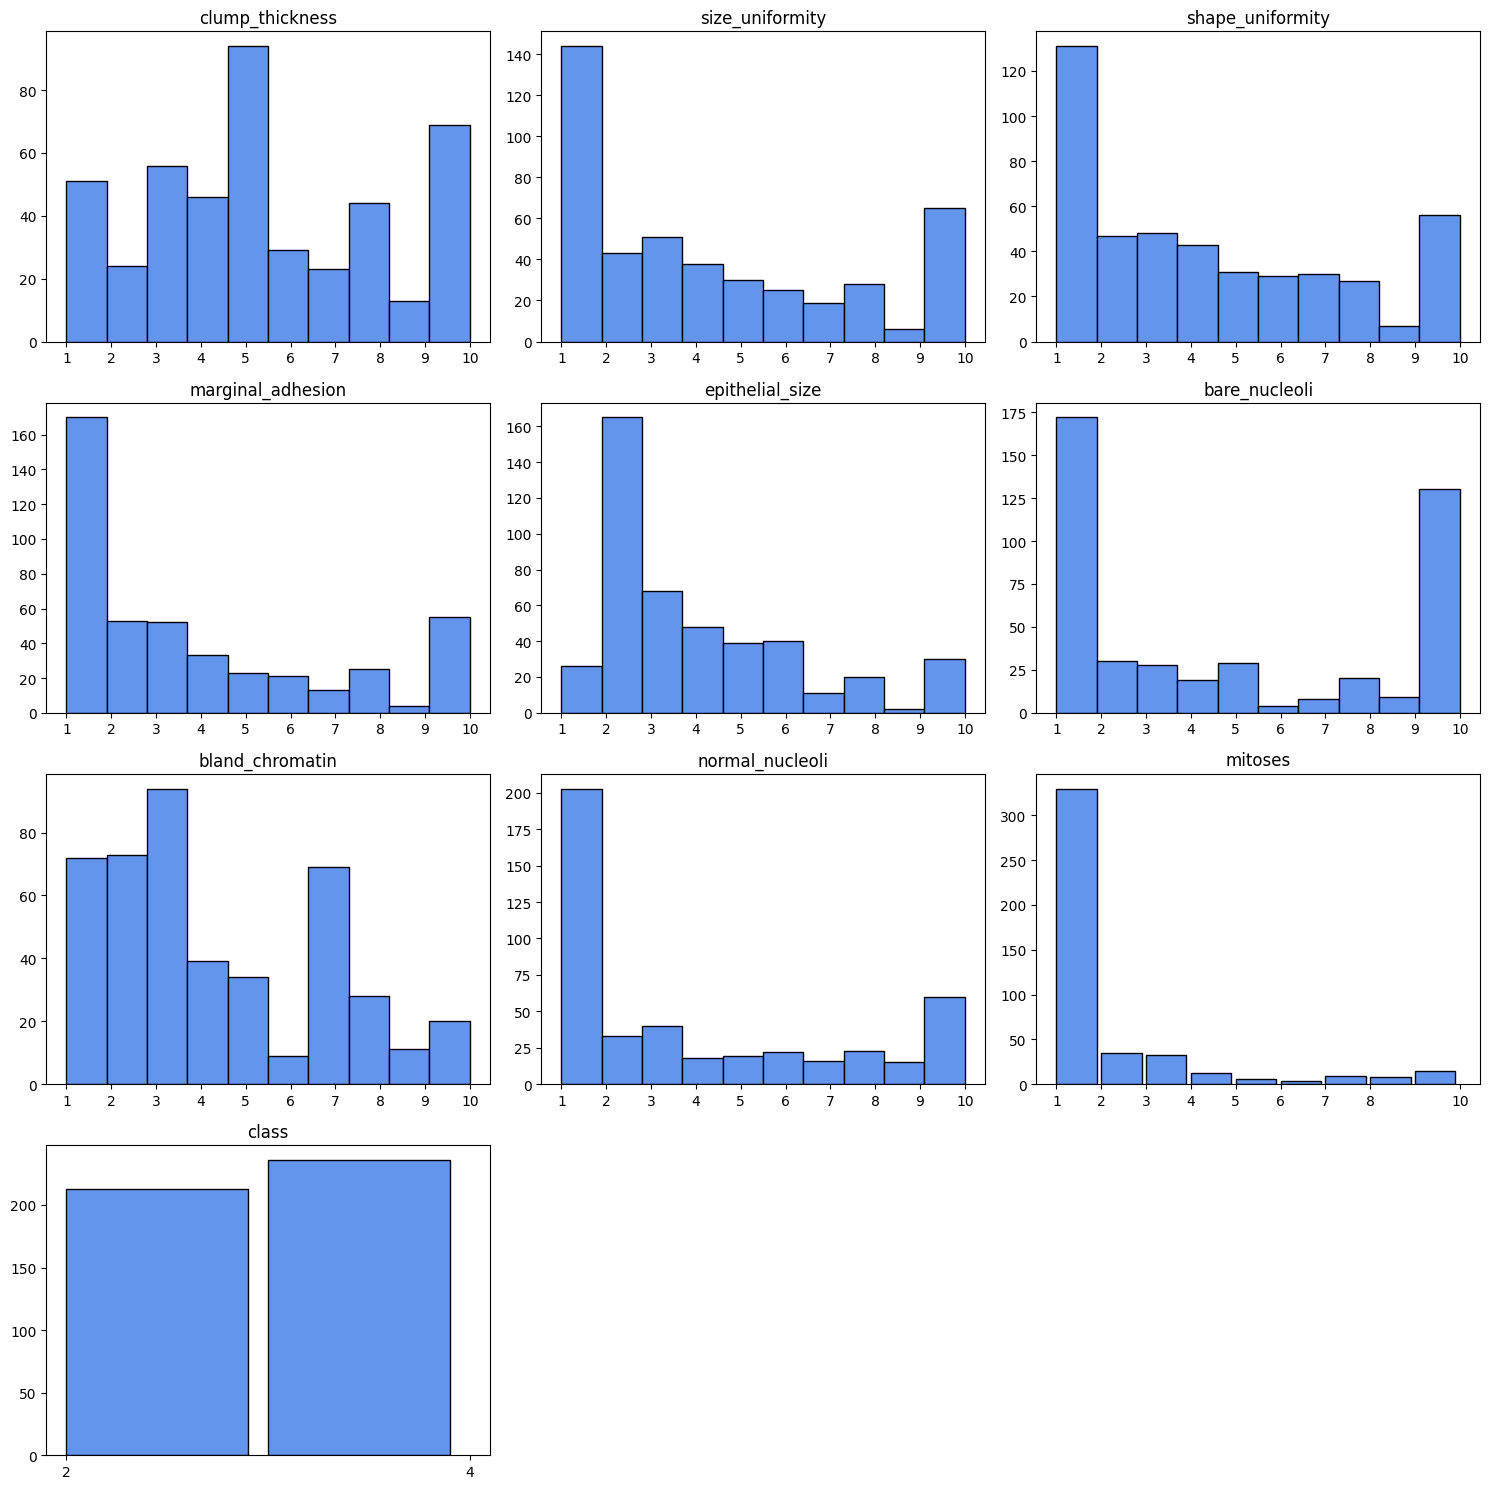

In [35]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i >= len(df.columns):
        ax.axis('off')
        continue
    col = df.columns[i]
    ax.hist(df[col], bins=len(df[col].unique()), color='cornflowerblue', edgecolor='black', width=0.9)
    ax.set_title(col)
    ax.set_xticks(df[col].unique())

plt.tight_layout()

Аномальных значений не наблюдается. Предварительная обработка закончена.

### Целевая переменная

Целевая переменная, которую необходимо предсказать - `class` - злокачественная опухоль или доброкачественная.

Эта переменная будет предсказывться по различным характеристикам клеток.

Уникальные значения:

In [36]:
df['class'].unique()

array([2, 4])

Переменная принимает значение 2, когда опухоль доброкачественная, 4 - когда злокачественная.

Для удобства, необходимо заменить значения на 0 (доброкачественная) и 1 (злокачественная).

In [37]:
df['class'] = df['class'].map({2: 0, 4: 1})

df['class'].unique()

array([0, 1])

Проверка сбалансированности классов

In [38]:
df['class'].value_counts(normalize=True) * 100

class
1    52.561247
0    47.438753
Name: proportion, dtype: float64

Дисбаланса классов не наблюдается

Матрица диаграмм рассеяния с выделением целевой переменной разными цветами

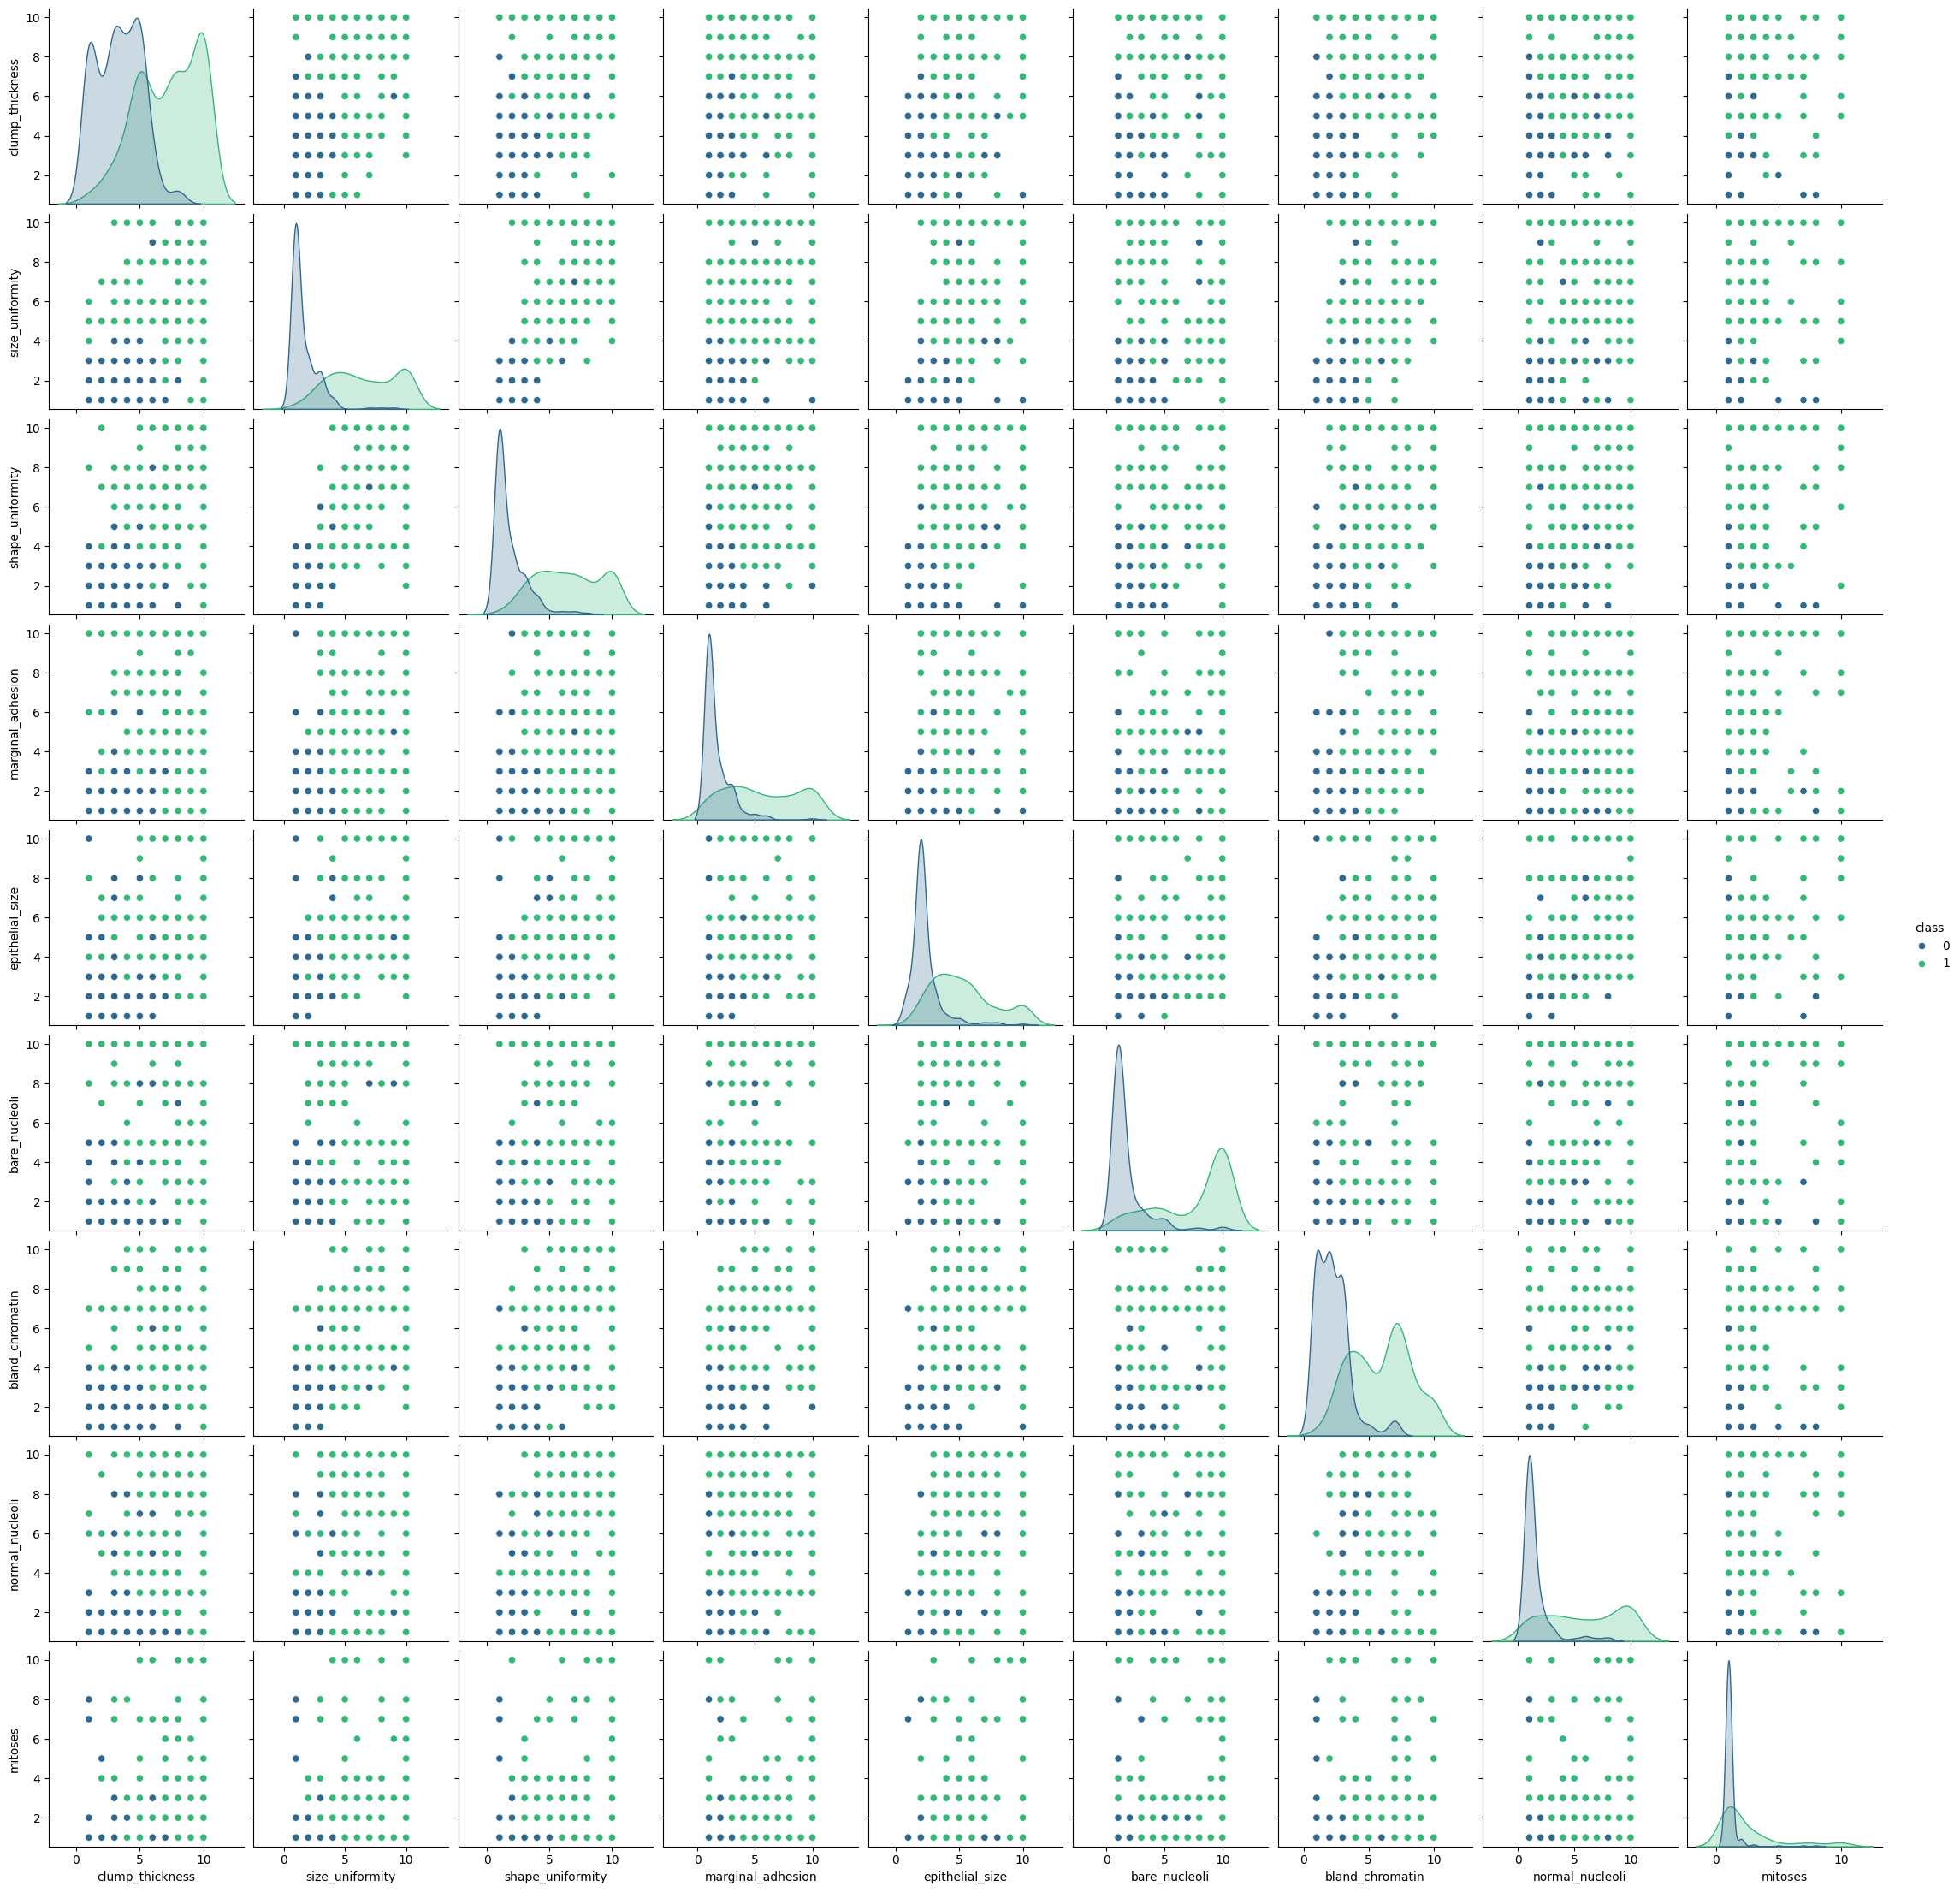

In [39]:
sns.pairplot(df, hue='class', palette='viridis', height=2.5)

Важный вывод из графиков:
- Если значение любого признака небольшое (до 5), то вероятнее всего, что это доброкачественная опухоль.

Выделение целевой переменной:

In [40]:
X = df.drop('class', axis=1)
y = df['class']

### KMeans

#### Подготовка

Разбиение данных на тренировочную и тестовую выборку

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Стандартизация

In [42]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Метод локтя

Подбор оптимального количества кластеров для KMeans с помощью метода локтя

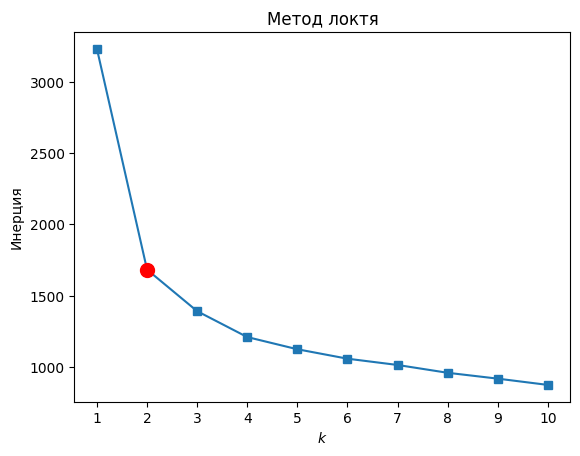

In [43]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='s')
plt.plot(2, inertia[1], marker='o', markersize=10, label='k=2', c='red')
plt.title('Метод локтя')

plt.xlabel('$k$')
plt.xticks(range(1, 11))
plt.ylabel('Инерция')

plt.show()

Видно, что оптимальное количество кластеров - 2. Неудивительно, ведь опухоль может быть или злокачественной, или доброкачественной

Кластеризация для k = 2

In [44]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)

train_labels = kmeans.fit_predict(X_train_scaled)

Предсказание для тестовых данных

In [45]:
test_labels = kmeans.predict(X_test_scaled)

#### Визуализация

График кластеризации для тренировочной выборки

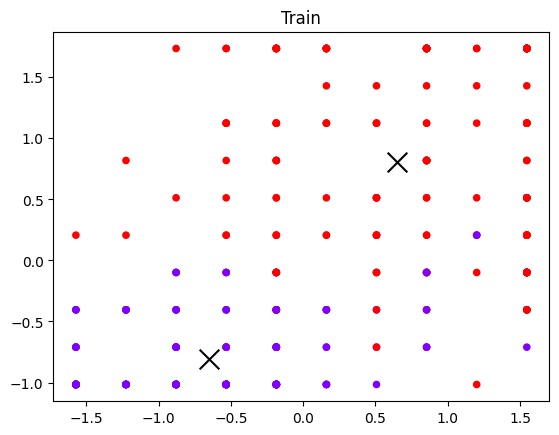

In [46]:
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=train_labels, cmap='rainbow', s=20)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='x')
plt.title('Train')
plt.show()

На основе данного графика тяжело сделать вывод о качестве кластеризации. В самих данных кластеры четко не выделены, соответственно и на результатах кластеризации тоже.

Вывод точечного графика по реальным значениям тренировочной выборки

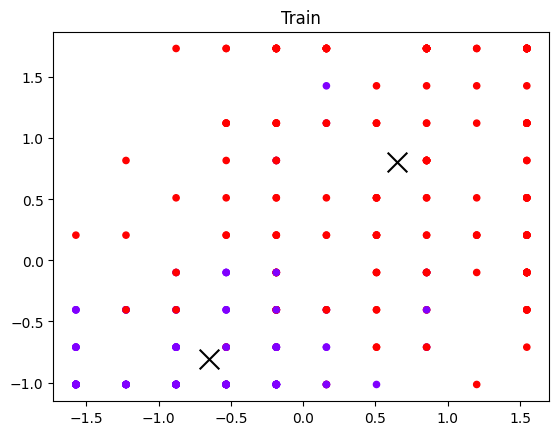

In [47]:
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='rainbow', s=20)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='x')
plt.title('Train')
plt.show()

Если сравнить два графика, то можно сделать вывод, что кластеризация отработала отлично. KMeans удалось уловить местоположения кластеров.

График кластеризации для тестовой выборки

Text(0.5, 1.0, 'Test')

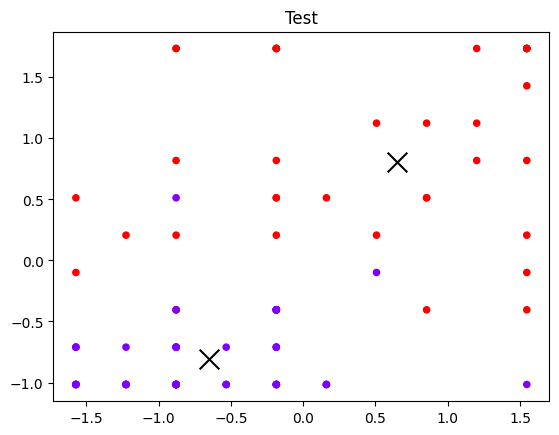

In [48]:
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=test_labels, cmap='rainbow', s=20)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='x')
plt.title('Test')

Видно, что кластеризация имеет хорошую обобщающую способность. Разбиение на кластеры у тестовой выборки такое же, как у тренировочной.

#### Метрики качества

Коэффициент силуэта

In [49]:
silhouette = silhouette_score(X_train_scaled, train_labels)
print(f'Silhouette Train: {silhouette}')

silhouette = silhouette_score(X_test_scaled, test_labels)
print(f'Silhouette Test: {silhouette}')

Silhouette Train: 0.4341218835461165
Silhouette Test: 0.4566665245610271


Видно, что коэффициент силуэта получился достаточно небольшим. Кластеризация не может четко определить границы классов

In [50]:
accuracy = accuracy_score(y_test, test_labels)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9444444444444444


Качество модели высокое

In [51]:
f1 = f1_score(y_test, test_labels)
print(f'f1-score: {f1}')

f1-score: 0.935064935064935


f1-score у модели высокий

Индекс Фоулкса — Мэллова (FMI)

In [52]:
fmi = fowlkes_mallows_score(y_test, test_labels)
print(f'FMI: {fmi}')

FMI: 0.8953577143506334


Индекс Фоулкса-Мэллоуза равен 0.9, что говорит о том, что кластеризация хорошо согласуется с исходными метками классов.

Запись метрик в датафрейм

In [53]:
metrics = pd.DataFrame(columns=[
    'model',
    'silhouette',
    'accuracy',
    'f1-score',
    'fmi'
])

metrics.loc[len(metrics)] = {
    'model': 'KMeans (k=2)',
    'silhouette': silhouette_score(X_test_scaled, test_labels),
    'accuracy': accuracy_score(y_test, test_labels),
    'f1-score': f1_score(y_test, test_labels),
    'fmi': fowlkes_mallows_score(y_test, test_labels)
}

metrics

,model,silhouette,accuracy,f1-score,fmi
0,KMeans (k=2),0.456667,0.944444,0.935065,0.895358


Видно, что силуэт гораздо ниже остальных метрик.

Возможно, данные таким образом распределены, что KMeans почти идеально разделяет их на два кластера, которые соответствуют истинным меткам, но из-за внутренней неоднородности данных или близости кластеров между собой, Silhouette score остается низким.


#### Анализ кластеров

In [54]:
pd.set_option('display.max_columns', None)

X_train['cluster_kmeans'] = train_labels
X_test['cluster_kmeans'] = test_labels

df_kmeans = pd.concat([X_train, X_test])

df_kmeans.groupby('cluster_kmeans').agg(['mean', 'median', 'min', 'max', lambda x: x.value_counts().index[0]]).rename(columns={'<lambda_0>': 'mode'})

clump_thickness                     size_uniformity             \
                          mean median min max mode            mean median min   
cluster_kmeans                                                                  
0                     3.649573    3.0   1  10    5        1.692308    1.0   1   
1                     7.260465    8.0   1  10   10        6.976744    7.0   1   

                        shape_uniformity                      \
               max mode             mean median min max mode   
cluster_kmeans                                                 
0                6    1         1.876068    1.0   1   8    1   
1               10   10         6.883721    7.0   2  10   10   

               marginal_adhesion                     epithelial_size         \
                            mean median min max mode            mean median   
cluster_kmeans                                                                
0                       1.692308    1.0   1  10    1        2.358974    2.0   
1                       5.981395    6.0   1  10   10        5.534884    5.0   

                            bare_nucleoli                     bland_chromatin  \
               min max mode          mean median min max mode            mean   
cluster_kmeans                                                                  
0                1  10    2      1.888889    1.0   1  10    1        2.350427   
1                2  10    4      7.981395   10.0   1  10   10        6.213953   

                                   normal_nucleoli                      \
               median min max mode            mean median min max mode   
cluster_kmeans                                                           
0                 2.0   1   7    1        1.632479    1.0   1  10    1   
1                 7.0   1  10    7        6.218605    7.0   1  10   10   

                 mitoses                      
                    mean median min max mode  
cluster_kmeans                                
0               1.230769    1.0   1  10    1  
1               2.655814    1.0   1  10    1

Каждый признак принимает значение от 1 до 10.

Класс 0 - доброкачественная опухоль, 1 - злокачественная


1. clump_thickness - толщина скопления

- среднее
  у класса 0: 3.649573
  у класса 1: 7.260465

- медиана
  у класса 0: 3
  у класса 1: 8

- мода
  у класса 0: 5
  у класса 1: 10

Вывод:

При злокачественных опухолях толщина скопления больше.

2. size_uniformity - однородность размера клеток

- среднее
  у класса 0: 1.692308
  у класса 1: 6.976744

- медиана
  у класса 0: 1
  у класса 1: 7

- максимум
  у класса 0: 6
  у класса 1: 10

- мода
  у класса 0: 1
  у класса 1: 10

Вывод:

При злокачественных опухолях однородность размера клеток больше.

3. shape_uniformity	- однородность формы клеток

- среднее
  у класса 0: 1.876068
  у класса 1: 6.883721

- медиана
  у класса 0: 1
  у класса 1: 7

- минимум
  у класса 0: 1
  у класса 1: 2

- максимум
  у класса 0: 8
  у класса 1: 10

- мода
  у класса 0: 1
  у класса 1: 10

Вывод:

При злокачественных опухолях однородность формы клеток больше.

4. marginal_adhesion - краевая адгезия

- среднее
  у класса 0: 1.692308
  у класса 1: 5.981395

- медиана
  у класса 0: 1
  у класса 1: 6

- минимум
  у класса 0: 1
  у класса 1: 1

- максимум
  у класса 0: 10
  у класса 1: 10

- мода
  у класса 0: 1
  у класса 1: 10

Вывод:

При злокачественных опухолях краевая адгезия более выраженна.

5. epithelial_size - размер отдельных эпителиальных клеток

- среднее
  у класса 0: 2.358974
  у класса 1: 5.534884

- медиана
  у класса 0: 2
  у класса 1: 5

- минимум
  у класса 0: 1
  у класса 1: 2

- максимум
  у класса 0: 10
  у класса 1: 10

- мода
  у класса 0: 2
  у класса 1: 4

Вывод:

При злокачественных опухолях размер отдельных эпителиальных клеток чуть больше.


6. bare_nucleoli - голые ядра

- среднее
  у класса 0: 1.888889
  у класса 1: 7.981395

- медиана
  у класса 0: 1
  у класса 1: 10

- минимум
  у класса 0: 1
  у класса 1: 1

- максимум
  у класса 0: 10
  у класса 1: 10

- мода
  у класса 0: 1
  у класса 1: 10

Вывод:

При злокачественных опухолях показатель голых ядер значительно больше.


7. bland_chromatin - бледный хроматин
   
- среднее
  у класса 0: 2.350427
  у класса 1: 6.213953

- медиана
  у класса 0: 2
  у класса 1: 7

- минимум
  у класса 0: 1
  у класса 1: 1

- максимум
  у класса 0: 7
  у класса 1: 10

- мода
  у класса 0: 1
  у класса 1: 7

Вывод:

При злокачественных опухолях показатель бледного хроматина чуть больше.

8. normal_nucleoli - нормальные ядрышки

- среднее
  у класса 0: 1.632479
  у класса 1: 6.218605

- медиана
  у класса 0: 1
  у класса 1: 7

- минимум
  у класса 0: 1
  у класса 1: 1

- максимум
  у класса 0: 10
  у класса 1: 10

- мода
  у класса 0: 1
  у класса 1: 10

Вывод:

При злокачественных опухолях показатель нормальных ядрышек больше.

9.  mitoses - митозы

- среднее
  у класса 0: 1.230769
  у класса 1: 2.655814

- медиана
  у класса 0: 1
  у класса 1: 1

- минимум
  у класса 0: 1
  у класса 1: 1

- максимум
  у класса 0: 10
  у класса 1: 10

- мода
  у класса 0: 1
  у класса 1: 1

Вывод:

Митозы слабо влияют на опухоли.

### Агломеративная кластеризация

#### AgglomerativeClustering

Сетка гиперпараметров для агломеративной кластеризации

In [55]:
# param_grid = {
#     'n_clusters': range(2, 11),
#     'linkage': ['ward', 'complete', 'average', 'single', 'centroid'], # 'median' не поддерживается
#     'metric': ['euclidean', 'manhattan', 'cosine']
# }

param_grid = {
    'n_clusters': range(2, 11),
    'linkage': ['ward', 'complete', 'average', 'single'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

In [56]:
def valid_param_comb(param) -> bool:
    if param['linkage'] == 'ward' and param['metric'] != 'euclidean':
        return False
    return True

from sklearn.model_selection import ParameterGrid

filtered_params = [
    param for param in ParameterGrid(param_grid)
    if valid_param_comb(param)
]

# Перебор параметров
best_score = -np.inf
best_params = None

Функция метрики силуэта

In [57]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

Подбор гиперпараметров и вывод лучших

In [58]:
for params in filtered_params:
    agg = AgglomerativeClustering(
        n_clusters=params['n_clusters'],
        linkage=params['linkage'],
        metric=params['metric']
    )
    try:
        score = silhouette_scorer(agg, X_train_scaled)
        if score > best_score:
            best_score = score
            best_params = params
    except Exception as e:
        print(f"Ошибка для параметров {params}: {e}")

print(f"Лучшие параметры: {best_params}")
print(f"Лучший силуэт: {best_score}")

Лучшие параметры: {'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 2}
Лучший силуэт: 0.4286469041203478


In [59]:
# agg = AgglomerativeClustering()
# grid = GridSearchCV(agg, param_grid, cv=5, n_jobs=-1, scoring=silhouette_scorer)
# grid.fit(X_train_scaled)
# grid.best_params_

Наилучшее число кластеров - 2.

Применение кластеризации с полученными гиперпараметрами

In [60]:
agg = AgglomerativeClustering(**best_params)
best_params

train_labels = agg.fit_predict(X_train_scaled)
test_labels = agg.fit_predict(X_test_scaled)

silhouette = silhouette_score(X_test_scaled, test_labels)
print(f'Silhouette Test: {silhouette}')
silhouette = silhouette_score(X_train_scaled, train_labels)
print(f'Silhouette Train: {silhouette}')
print()
accuracy = accuracy_score(y_test, test_labels)
print(f'Accuracy Test: {accuracy}')
accuracy = accuracy_score(y_train, train_labels)
print(f'Accuracy Train: {accuracy}')
print()
f1 = f1_score(y_test, test_labels)
print(f'f1-score Test: {f1}')
f1 = f1_score(y_train, train_labels)
print(f'f1-score Train: {f1}')

Silhouette Test: 0.4358831815076401
Silhouette Train: 0.4286469041203478

Accuracy Test: 0.03333333333333333
Accuracy Train: 0.04735376044568245

f1-score Test: 0.0
f1-score Train: 0.05


Заметна странная просадка по accuracy и f1-score.

Возможно, что это типичная проблема связанная при подсчете метрик бинарной классификации. Скорее всего, метки классов инвертированы.

Сравнение меток ответа и меток кластеров:

In [61]:
test_labels

array([1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0])

In [62]:
y_test.values

array([0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1])

Да, это действительно так.

Перед подсчетом метрик необходимо инвертировать метки.

In [63]:
test_labels_inversed = 1 - test_labels
train_labels_inversed = 1 - train_labels

Переподсчет метрик

In [64]:
accuracy = accuracy_score(y_test, test_labels_inversed)
print(f'Accuracy Test: {accuracy}')
accuracy = accuracy_score(y_train, train_labels_inversed)
print(f'Accuracy Train: {accuracy}')
print()
f1 = f1_score(y_test, test_labels_inversed)
print(f'f1-score Test: {f1}')
f1 = f1_score(y_train, train_labels_inversed)
print(f'f1-score Train: {f1}')

Accuracy Test: 0.9666666666666667
Accuracy Train: 0.9526462395543176

f1-score Test: 0.9647058823529412
f1-score Train: 0.9562982005141388


Теперь метрики выглядят более правдоподобно

Запись метрик в датафрейм

In [65]:
metrics.loc[len(metrics)] = {
    'model': 'Agglomerative Clustering',
    'silhouette': silhouette_score(X_test_scaled, test_labels),
    'accuracy': accuracy_score(y_test, test_labels_inversed),
    'f1-score': f1_score(y_test, test_labels_inversed),
    'fmi': fowlkes_mallows_score(y_test, test_labels_inversed)
}

metrics

,model,silhouette,accuracy,f1-score,fmi
0,KMeans (k=2),0.456667,0.944444,0.935065,0.895358
1,Agglomerative Clustering,0.435883,0.966667,0.964706,0.934379


Агломеративная кластеризация способна решить эту задачу, но чуть хуже, чем KMeans. Видны просадки не только по accuracy и f1, но и по силуэту.

Значение FMI также просело.

#### Дендрограмма

Построение дендрограммы.

Для лучшей наглядности на ось ординат были нанесены истинные метки кластеров.

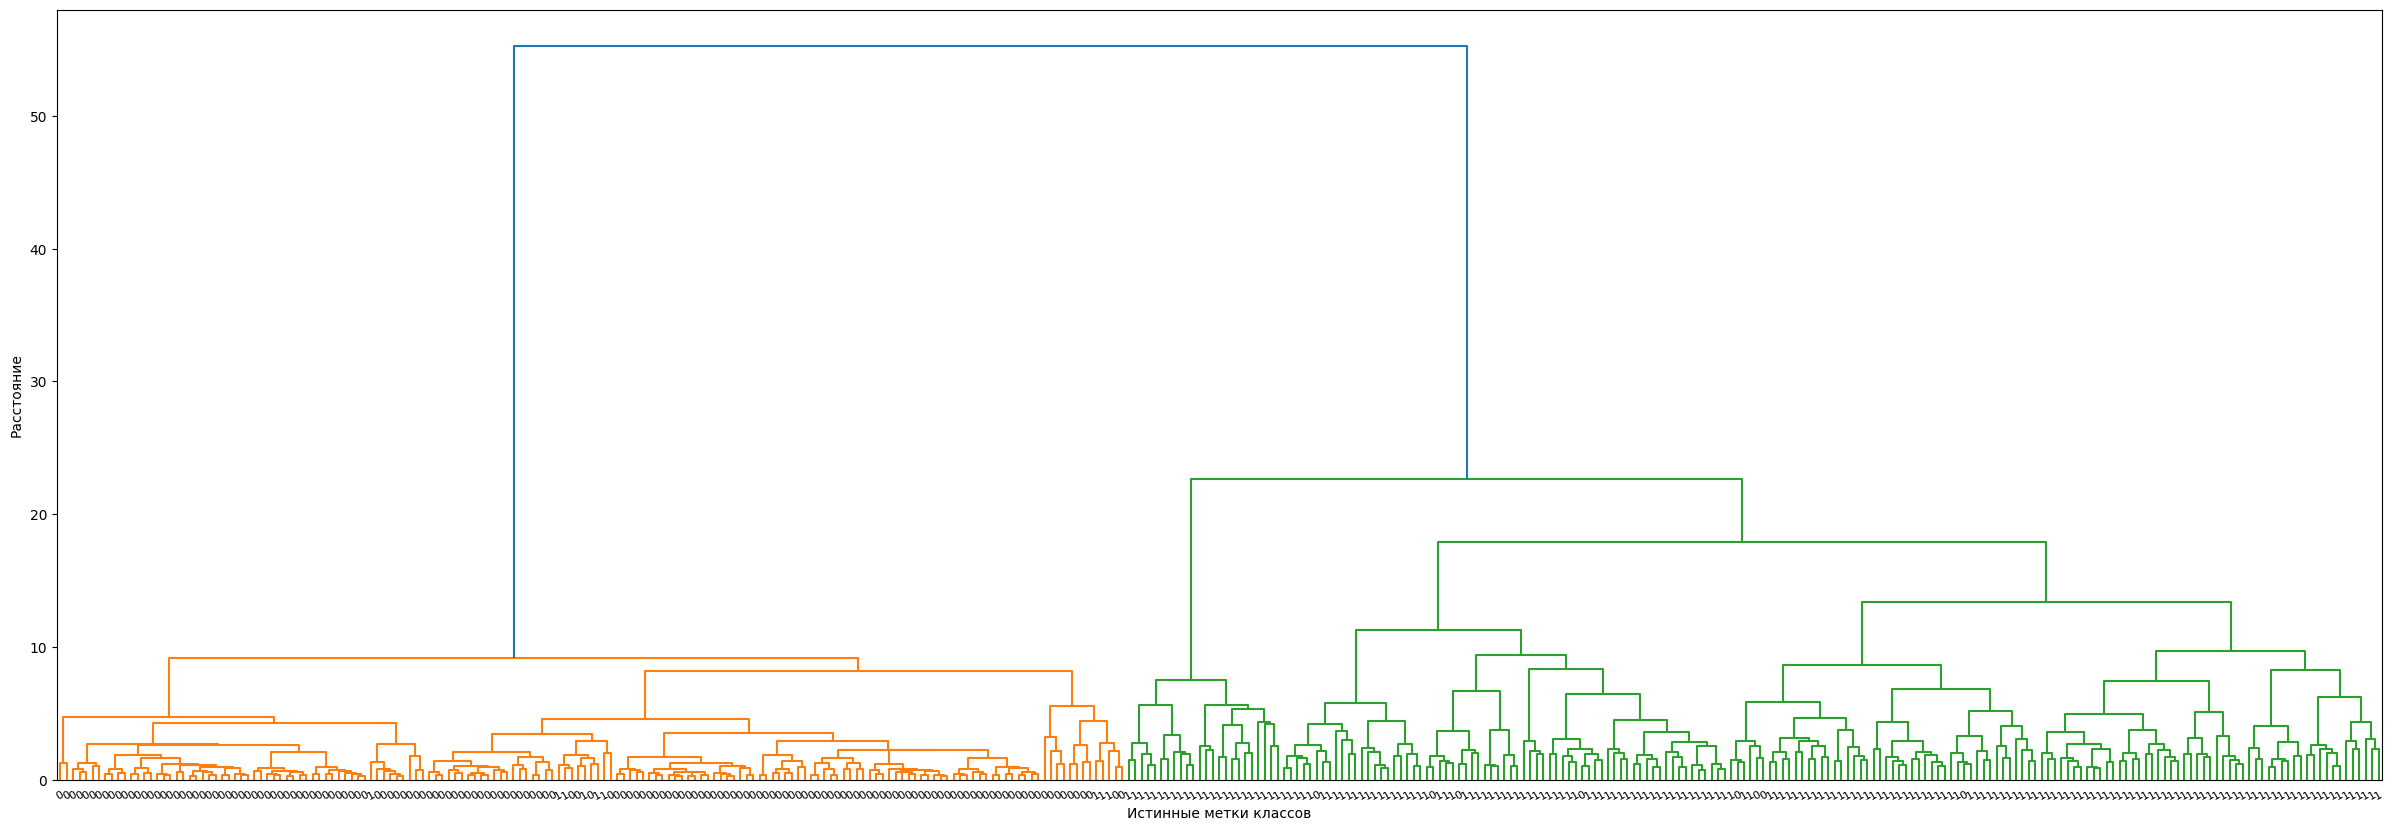

In [66]:
linkage_matrix = linkage(X_train_scaled, method='ward')

plt.figure(figsize=(30, 10))

dendrogram(linkage_matrix,
           orientation='top',
           labels=y_train.values,
           no_labels=False,
           leaf_font_size=8,
           leaf_rotation=30)

plt.xlabel('Истинные метки классов')
plt.ylabel('Расстояние')
plt.show()

Видно, что дендрограмма очень глубокая. Чтобы выполнить кластеризацию, модели пришлось провести много сравнений.

Тем не менее, на начальных уровнях, объекты уверенно разбиваются на классы. Это происходит потому, что на ранних этапах объекты кластеризуются по явным признакам, и различия между ними достаточно велики, чтобы разделение было очевидным.


Также, по истинным меткам классов, можно сказать о том, что кластеризация прошла достаточно хорошо.

#### Анализ кластеров

In [67]:
pd.set_option('display.max_columns', None)

X_train['agg_cluster'] = train_labels_inversed
X_test['agg_cluster'] = test_labels_inversed

df_agg = pd.concat([X_train, X_test])
df_agg = df_agg.drop('cluster_kmeans', axis=1)

df_agg.groupby('agg_cluster').agg(['mean', 'median', 'min', 'max', lambda x: x.value_counts().index[0]]).rename(columns={'<lambda_0>': 'mode'})

clump_thickness                     size_uniformity             \
                       mean median min max mode            mean median min   
agg_cluster                                                                  
0                  3.341232    3.0   1  10    1        1.507109    1.0   1   
1                  7.184874    8.0   1  10   10        6.630252    6.0   1   

                     shape_uniformity                     marginal_adhesion  \
            max mode             mean median min max mode              mean   
agg_cluster                                                                   
0             4    1         1.663507    1.0   1   6    1          1.516588   
1            10   10         6.588235    7.0   1  10   10          5.722689   

                                epithelial_size                      \
            median min max mode            mean median min max mode   
agg_cluster                                                           
0              1.0   1   6    1        2.218009    2.0   1  10    2   
1              5.0   1  10   10        5.352941    5.0   2  10    3   

            bare_nucleoli                     bland_chromatin                 \
                     mean median min max mode            mean median min max   
agg_cluster                                                                    
0                1.582938    1.0   1  10    1        2.175355    2.0   1   7   
1                7.663866   10.0   1  10   10        5.995798    7.0   1  10   

                 normal_nucleoli                       mitoses                 \
            mode            mean median min max mode      mean median min max   
agg_cluster                                                                     
0              1        1.497630    1.0   1  10    1  1.137441    1.0   1   8   
1              7        5.894958    6.0   1  10   10  2.600840    1.0   1  10   

                  
            mode  
agg_cluster       
0              1  
1              1

Каждый признак принимает значение от 1 до 10.

Класс 0 - доброкачественная опухоль, 1 - злокачественная


1. clump_thickness - толщина скопления

- среднее
  у класса 0: 4.151515
  у класса 1: 5.590078

- медиана
  у класса 0: 4
  у класса 1: 5

- мода
  у класса 0: 5
  у класса 1: 5

Вывод:

Ранее при анализе KMeans был сделан вывод: "При злокачественных опухолях толщина скопления больше". Сейчас же эта зависимость совсем неочевидна.

2. size_uniformity - однородность размера клеток

- среднее
  у класса 0: 2.515152
  у класса 1: 4.516971

- медиана
  у класса 0: 2
  у класса 1: 4

- максимум
  у класса 0: 10
  у класса 1: 10

- мода
  у класса 0: 1
  у класса 1: 1

Вывод:

Ранее при анализе KMeans был сделан вывод: "При злокачественных опухолях однородность размера клеток больше". Сейчас же эта зависимость совсем неочевидна.

3. shape_uniformity	- однородность формы клеток

- среднее
  у класса 0: 2.545455
  у класса 1: 4.571802

- медиана
  у класса 0: 1.5
  у класса 1: 4.0

- минимум
  у класса 0: 1
  у класса 1: 1

- максимум
  у класса 0: 10
  у класса 1: 10

- мода
  у класса 0: 1
  у класса 1: 1

Вывод:

Ранее при анализе KMeans был сделан вывод: "При злокачественных опухолях однородность формы клеток больше". Сейчас же эта зависимость совсем неочевидна.

...

Вывод:

Агломеративная кластеризация отработала гораздо хуже, чем KMeans.

Несмотря на схожее значение силуэта и метрики качества, модель стала гораздо менее чувствительной к признакам.

Абсолютно все зависимости, которые в KMeans четко прослеживались по медиане, моде и крайним значениям, сейчас совсем незаметны.

Восстановить прошлые зависимости можно лишь при помощи сравнения средних значений. Они немного отличаются, но знаки изменений соответствуют предыдущим зависимостям.

### Вывод по второй части работы

Вторая часть лабораторной работы была посвящена работе с датасетом, содержащим информацию о людях, больных раком.

После предварительной обработки данных на этом датасете была обучена модель **KMeans** с числом кластеров, равным 2. Количество кластеров было выбрано с использованием метода локтя.

Модель **KMeans**, несмотря на среднее значение коэффициента силуэта, продемонстрировала высокие значения метрик **F1-score**, **accuracy** и **FMI**.

Кроме того, при анализе кластеров удалось выявить важные зависимости в данных. Обобщая, можно сказать, что вероятность злокачественного образования высока, если все предложенные в датасете показатели здоровья имеют большие значения.

Затем была обучена модель агломеративной кластеризации, а именно **AgglomerativeClustering**, гиперпараметры которой подбирались с помощью **GridSearchCV**. В этом случае число кластеров также было равно 2.

По коэффициенту силуэта и метрикам качества модель показала результаты немного хуже, чем **KMeans**. Однако дендрограмма модели продемонстрировала, что классы были определены достаточно хорошо.

Тем не менее, при анализе кластеров не удалось выявить четких зависимостей, как в случае с **KMeans**. Однако те же закономерности можно обнаружить при более детальном сравнении средних значений показателей в кластерах.

Подводя итог, модель **KMeans с двумя кластерами** справилась с задачей лучше.

## Вывод

В ходе лабораторной работы были изучены алгоритмы и методы кластеризации на практике. На первом этапе работы выполнялось исследование на синтетических данных, где были сгенерированы тестовые и тренировочные наборы с тремя кластерами. Были построены три модели KMeans с различными значениями числа кластеров ($k = 2, k = 3, k = 4$). Анализ коэффициента силуэта показал, что лучшая кластеризация достигается при $k = 3$. Дополнительно были рассчитаны значения инерции для десяти различных значений $k$, и применение метода локтя подтвердило, что оптимальное число кластеров равно трём.  

На втором этапе анализировались реальные данные о людях, больных раком. После предварительной обработки данных модель KMeans была обучена с числом кластеров, равным двум, которое также было выбрано на основании метода локтя. Несмотря на средний уровень коэффициента силуэта, эта модель продемонстрировала высокие значения метрик F1-score, accuracy и FMI. Кроме того, анализ кластеров позволил выявить закономерности в данных: вероятность злокачественного образования возрастает, если все показатели здоровья, представленные в датасете, имеют высокие значения.  

Помимо KMeans, для тех же данных была построена модель агломеративной кластеризации с использованием метода AgglomerativeClustering. Её гиперпараметры подбирались с помощью GridSearchCV, а оптимальным числом кластеров также оказалось два. Результаты модели по коэффициенту силуэта и метрикам качества оказались немного хуже, чем у KMeans. Однако дендрограмма продемонстрировала, что классы определены достаточно хорошо. При этом в кластерах агломеративной модели не удалось выявить столь чётких зависимостей, как в случае с KMeans, хотя аналогичные закономерности могли быть обнаружены при более глубоком анализе средних значений показателей.  

Таким образом, можно сделать вывод, что модель KMeans с двумя кластерами справилась с задачей лучше, выявив важные зависимости в данных и показав более высокие результаты по ключевым метрикам.